In [1]:
import sys
import os
from scipy import stats
sys.path.append("../..")
from diachr import DiachromaticInteractionSet
from diachr import UnbaitedFragmentAnalysis

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'results/unbaited_fragment_analysis'
%mkdir -p $NOTEBOOK_RESULTS_DIR

# Unbaited fragment analysis

In this notebook, we analyze unbaited fragments in terms of length, GC and repeat content. In order to keep the layout of the notebook clear, we outsourced some parts of the analysis to a separate module.

In [2]:
ub_frag_analysis = UnbaitedFragmentAnalysis()

## Loading interaction data

### Choose an interaction file

In [3]:
AUTHOR = 'MIF' # JAV, SCH, MIF
PROTOCOL = 'CHC' # HC or CHC
CELL_TYPE_SHORT = 'GM12878' # MK, ERY, NEU, MON, MAC_M0, ..., MESC, MFLC, MESC_R1ABKO, GM12878
OUT_PREFIX = AUTHOR + '_' + CELL_TYPE_SHORT + '_' + PROTOCOL +'_REPC'
INTERACTION_FILE = '../../UICer_interactions/' + PROTOCOL + '/' + OUT_PREFIX + '_evaluated_and_categorized_interactions.tsv.gz' 

### Read interactions into data structure

In [4]:
# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../../UICer_interactions/CHC/MIF_GM12878_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Set size: 1,892,588
[INFO] ... done.


### Path to the corresponding reference sequence

In [5]:
GENOME_FILE = '../../additional_files/reference_sequence/hg38_genome.fa'

## Get two fragment sets associated with either balanced or unbalanced interactions

A given fragment can be associated with both balanced and unbalanced interactions. Therefore we determine two sets of fragments associated either only with balanced or only with unbalanced interactions.

In [6]:
RESTRICT_TO_BFC0 = False

# Get set of BFC0 fragments
BFC0_SET = set()
if RESTRICT_TO_BFC0:
    import pybedtools
    BFC0_BED_FILE = 'results/baited_fragment_classification' + '/bfc_lists/' + AUTHOR + '/' + OUT_PREFIX  + '_bfc0.bed'
    BFC0_BT_FILE = pybedtools.BedTool(BFC0_BED_FILE)
    BFC0_SET = set()
    for d in BFC0_BT_FILE:
        BFC0_SET.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
    
# Get unbaited fragments associated with baited fragments of class BFC0
B_FRAGS = set()
U_FRAGS = set()
for d_inter in d11_interaction_set.interaction_list:
    
    # Skip interaction that are not baited-other or other-baited
    if d_inter.enrichment_status_tag_pair == 'NN' or d_inter.enrichment_status_tag_pair == 'EE':
        continue
        
    # Get coordinates of associated fragments
    frag_5 = d_inter.chrA + '\t' + str(d_inter.fromA) + '\t' + str(d_inter.toA)
    frag_3 = d_inter.chrB + '\t' + str(d_inter.fromB) + '\t' + str(d_inter.toB)

    # Balanced interactions
    if d_inter.get_category() == 'BR' or d_inter.get_category() == 'BX':
        if frag_5 in BFC0_SET or frag_3 in BFC0_SET or not RESTRICT_TO_BFC0:
            if d_inter.enrichment_status_tag_pair == 'NE':
                B_FRAGS.add(frag_5)
            else:
                B_FRAGS.add(frag_3)
                
    # Unbalanced interactions
    if d_inter.get_category() == 'UR' or d_inter.get_category() == 'UX':
        if frag_5 in BFC0_SET or frag_3 in BFC0_SET or not RESTRICT_TO_BFC0:
            if d_inter.enrichment_status_tag_pair == 'NE':
                U_FRAGS.add(frag_5)
            else:
                U_FRAGS.add(frag_3)
                
# Get subsets of fragments involved in either only balanced or only unbalanced interactions
BO_FRAGS = B_FRAGS.difference(U_FRAGS)
UO_FRAGS = U_FRAGS.difference(B_FRAGS)

## Fragment length analysis

### Get lists of fragment lengths for balanced and unbalanced fragments

In [7]:
B_FRAG_LEN_LIST = list()
U_FRAG_LEN_LIST = list()
for frag in BO_FRAGS:
    chrom, sta, end = frag.split('\t')
    f_len = int(end) - int(sta)
    B_FRAG_LEN_LIST.append(f_len)
for frag in UO_FRAGS:
    chrom, sta, end = frag.split('\t')
    f_len = int(end) - int(sta)
    U_FRAG_LEN_LIST.append(f_len)

### Report summary statistics and test

In [8]:
ub_frag_analysis.get_summary_report(b_list=B_FRAG_LEN_LIST, u_list=U_FRAG_LEN_LIST, test='MWU')

Fragments involved only in balanced interactions: 198,051
Fragments involved only in unbalanced interactions: 64,080
Median for fragments involved only in balanced interactions: 2,301
Median for fragments involved only in unbalanced interactions: 2,843
Test whether fragment lengths differ significantly: Balanced vs. unbalanced
	MannwhitneyuResult(statistic=5687503291.5, pvalue=0.0)
	MannwhitneyuResult(statistic=7003604788.5, pvalue=0.0)


### Create boxplot

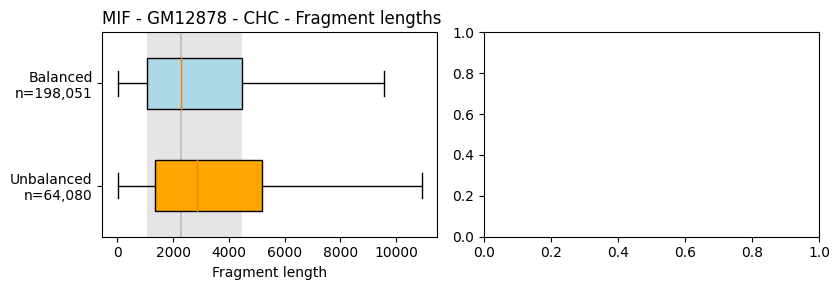

In [9]:
ub_frag_analysis.create_boxplots(
    u_list=U_FRAG_LEN_LIST,
    b_list=B_FRAG_LEN_LIST,
    showfliers=False,
    title= AUTHOR + ' - ' + CELL_TYPE_SHORT + ' - ' + PROTOCOL + ' - Fragment lengths',
    xlabel='Fragment length',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_restriction_fragment_lengths_boxplots.pdf')

### Create distribution histograms

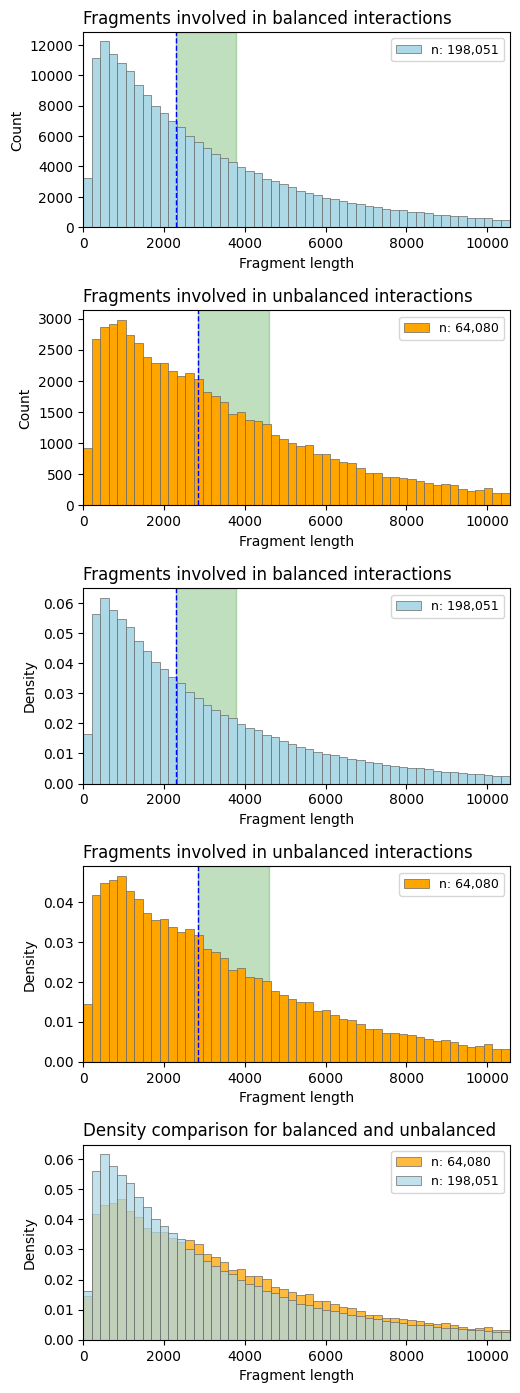

In [10]:
ub_frag_analysis.create_histplots(
    b_list = B_FRAG_LEN_LIST,
    u_list = U_FRAG_LEN_LIST,
    q_lim = 0.95,
    n_bins=50,
    xlabel='Fragment length',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_restriction_fragment_lengths_histograms.pdf')

### Remove short fragments

For datasets with extremely high sequencing depth, we observe many particularly short fragments among the fragments from unbalanced interactions. We remove these fragments from both comparison sets to make another difference between the two sets more visible.

In [11]:
min_frag_len = 250
B_FRAG_LEN_LIST_RMS = [x for x in B_FRAG_LEN_LIST if min_frag_len < x]
U_FRAG_LEN_LIST_RMS = [x for x in U_FRAG_LEN_LIST if min_frag_len < x]

### Report summary statistics and test

In [12]:
ub_frag_analysis.get_summary_report(b_list=B_FRAG_LEN_LIST_RMS, u_list=U_FRAG_LEN_LIST_RMS, test='MWU')

Fragments involved only in balanced interactions: 193,079
Fragments involved only in unbalanced interactions: 62,738
Median for fragments involved only in balanced interactions: 2,378
Median for fragments involved only in unbalanced interactions: 2,912
Test whether fragment lengths differ significantly: Balanced vs. unbalanced
	MannwhitneyuResult(statistic=5424801548.0, pvalue=0.0)
	MannwhitneyuResult(statistic=6688588754.0, pvalue=0.0)


### Create boxplots

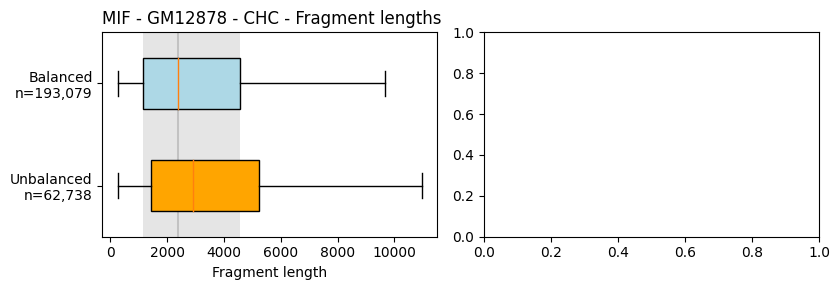

In [13]:
ub_frag_analysis.create_boxplots(
    u_list=U_FRAG_LEN_LIST_RMS,
    b_list=B_FRAG_LEN_LIST_RMS,
    showfliers=False,
    title= AUTHOR + ' - ' + CELL_TYPE_SHORT + ' - ' + PROTOCOL + ' - Fragment lengths',
    xlabel='Fragment length',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_restriction_fragment_lengths_boxplots_rms.pdf')

### Create distribution histograms

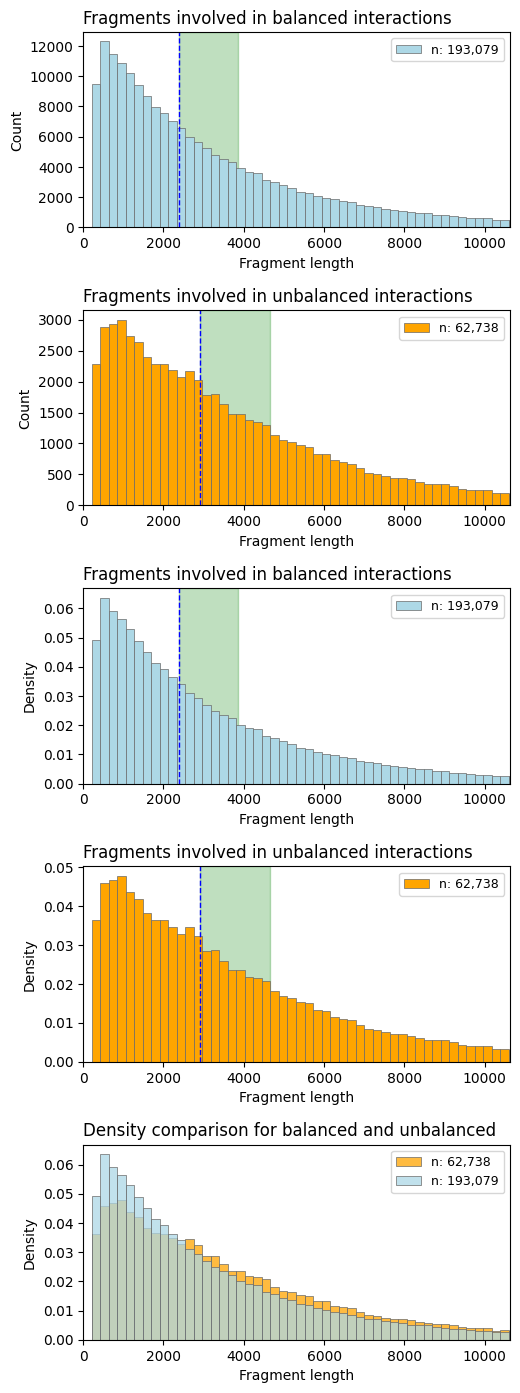

In [14]:
ub_frag_analysis.create_histplots(
    b_list = B_FRAG_LEN_LIST_RMS,
    u_list = U_FRAG_LEN_LIST_RMS,
    q_lim = 0.95,
    n_bins=50,
    xlabel='Fragment length',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_restriction_fragment_lengths_histograms_rms.pdf')

## GC and repeat content of fragment ends

### Create sequence dictionary

For the analysis of GC and repeat content, we create a data structure from which the sequences of fragment ends can be retrieved.

Create BED file with the coordinates of all fragment ends:

In [15]:
B_FRAG_END_53_PAIRS = list()
U_FRAG_END_53_PAIRS = list()
for frag in BO_FRAGS:
    chrom, sta, end = frag.split('\t')
    end_5 = chrom + '\t' + sta + '\t' + str(int(sta) + 120)
    end_3 = chrom + '\t' + str(int(sta) - 120) + '\t' + end
    B_FRAG_END_53_PAIRS.append((end_5, end_3))
for frag in UO_FRAGS:
    chrom, sta, end = frag.split('\t')
    end_5 = chrom + '\t' + sta + '\t' + str(int(sta) + 120)
    end_3 = chrom + '\t' + str(int(end) - 120) + '\t' + end
    U_FRAG_END_53_PAIRS.append((end_5, end_3))

Create BED file with the coordinates of all fragment ends:

In [16]:
fp = open(NOTEBOOK_RESULTS_DIR + '/all_only_frag_ends.bed', 'w')
for end_5, end_3 in B_FRAG_END_53_PAIRS + U_FRAG_END_53_PAIRS:
    fp.write(end_5 + '\n')
    fp.write(end_3 + '\n')
fp.close()

Create dictionary from which the sequences of fragment ends can be retrieved:

In [17]:
from diachr import BaitAnalysis
bait_analysis = BaitAnalysis()
bait_analysis.init_bait_seq_dict(genome_fasta_file=GENOME_FILE,
                                 bait_bed_file=NOTEBOOK_RESULTS_DIR + '/all_only_frag_ends.bed',
                                 working_directory=NOTEBOOK_RESULTS_DIR)

### Get lists containing the GC and repeat content of fragment ends

We create separate lists for the 5' and 3' ends of fragments so that we can later calculate the differences in GC or repeat content between the two fragment ends.

In [18]:
# Balanced
B_FRAG_ENDS_GC_5_LIST = list()
B_FRAG_ENDS_GC_3_LIST = list()
B_FRAG_ENDS_REPEAT_5_LIST = list()
B_FRAG_ENDS_REPEAT_3_LIST = list()
for end_5, end_3 in B_FRAG_END_53_PAIRS:    
    B_FRAG_ENDS_GC_5_LIST.append(bait_analysis.get_gc_content(end_5))
    B_FRAG_ENDS_GC_3_LIST.append(bait_analysis.get_gc_content(end_3))
    B_FRAG_ENDS_REPEAT_5_LIST.append(bait_analysis.get_repeat_content(end_5))  
    B_FRAG_ENDS_REPEAT_3_LIST.append(bait_analysis.get_repeat_content(end_3))

# Unbalanced
U_FRAG_ENDS_GC_5_LIST = list()
U_FRAG_ENDS_GC_3_LIST = list()
U_FRAG_ENDS_REPEAT_5_LIST = list()
U_FRAG_ENDS_REPEAT_3_LIST = list()
for end_5, end_3 in U_FRAG_END_53_PAIRS:
    U_FRAG_ENDS_GC_5_LIST.append(bait_analysis.get_gc_content(end_5))
    U_FRAG_ENDS_GC_3_LIST.append(bait_analysis.get_gc_content(end_3))
    U_FRAG_ENDS_REPEAT_5_LIST.append(bait_analysis.get_repeat_content(end_5))  
    U_FRAG_ENDS_REPEAT_3_LIST.append(bait_analysis.get_repeat_content(end_3))

## GC content analysis

For this analysis we combine the lists for the 5' and 3' ends:

In [19]:
B_FRAG_ENDS_GC_LIST = B_FRAG_ENDS_GC_5_LIST + B_FRAG_ENDS_GC_3_LIST
U_FRAG_ENDS_GC_LIST = U_FRAG_ENDS_GC_5_LIST + U_FRAG_ENDS_GC_3_LIST

### Report summary statistics and test

In [20]:
ub_frag_analysis.get_summary_report(b_list=B_FRAG_ENDS_GC_LIST, u_list=U_FRAG_ENDS_GC_LIST, test='RKS')

Fragments involved only in balanced interactions: 396,102
Fragments involved only in unbalanced interactions: 128,160
Median for fragments involved only in balanced interactions: 0.38
Median for fragments involved only in unbalanced interactions: 0.38
Test whether fragment lengths differ significantly: Balanced vs. unbalanced
	RanksumsResult(statistic=12.945765730789173, pvalue=2.4827526673509526e-38)
	RanksumsResult(statistic=-12.945765730789173, pvalue=2.4827526673509526e-38)


### Create boxplots

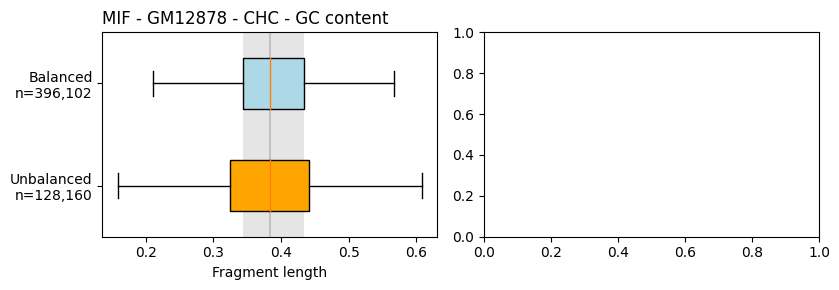

In [21]:
ub_frag_analysis.create_boxplots(
    u_list=U_FRAG_ENDS_GC_LIST,
    b_list=B_FRAG_ENDS_GC_LIST,
    showfliers=False,
    title= AUTHOR + ' - ' + CELL_TYPE_SHORT + ' - ' + PROTOCOL + ' - GC content',
    xlabel='Fragment length',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_boxplots.pdf')

### Create distribution histograms

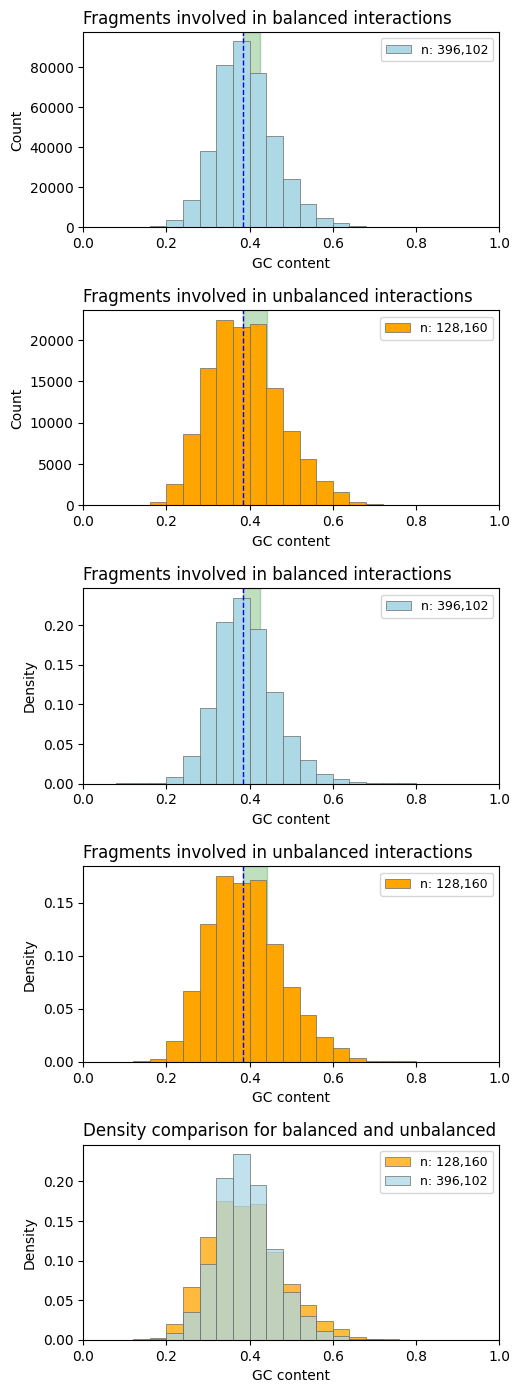

In [22]:
ub_frag_analysis.create_histplots(
    b_list = B_FRAG_ENDS_GC_LIST,
    u_list = U_FRAG_ENDS_GC_LIST,
    q_lim = 1.00,
    xlabel='GC content',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_histograms.pdf')

## Absolute difference in GC content of the two ends of given fragments

First, we calculate the absolute difference in the GC content of the two ends for each fragment:

In [23]:
U_FRAG_ENDS_GC_53_DIFF_LIST = [abs(x[0]-x[1]) for x in zip(U_FRAG_ENDS_GC_5_LIST, U_FRAG_ENDS_GC_3_LIST)]
B_FRAG_ENDS_GC_53_DIFF_LIST = [abs(x[0]-x[1]) for x in zip(B_FRAG_ENDS_GC_5_LIST, B_FRAG_ENDS_GC_3_LIST)]

### Report summary statistics and test

In [24]:
ub_frag_analysis.get_summary_report(b_list=B_FRAG_ENDS_GC_53_DIFF_LIST, u_list=U_FRAG_ENDS_GC_53_DIFF_LIST, test='RKS')

Fragments involved only in balanced interactions: 198,051
Fragments involved only in unbalanced interactions: 64,080
Median for fragments involved only in balanced interactions: 0.05
Median for fragments involved only in unbalanced interactions: 0.07
Test whether fragment lengths differ significantly: Balanced vs. unbalanced
	RanksumsResult(statistic=-103.9655593827431, pvalue=0.0)
	RanksumsResult(statistic=103.9655593827431, pvalue=0.0)


### Create boxplots

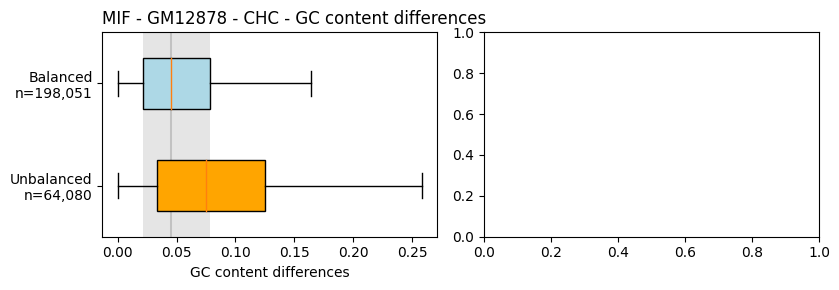

In [25]:
ub_frag_analysis.create_boxplots(
    u_list=U_FRAG_ENDS_GC_53_DIFF_LIST,
    b_list=B_FRAG_ENDS_GC_53_DIFF_LIST,
    showfliers=False,
    title= AUTHOR + ' - ' + CELL_TYPE_SHORT + ' - ' + PROTOCOL + ' - GC content differences',
    xlabel='GC content differences',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_difference.pdf')

### Create distribution histograms

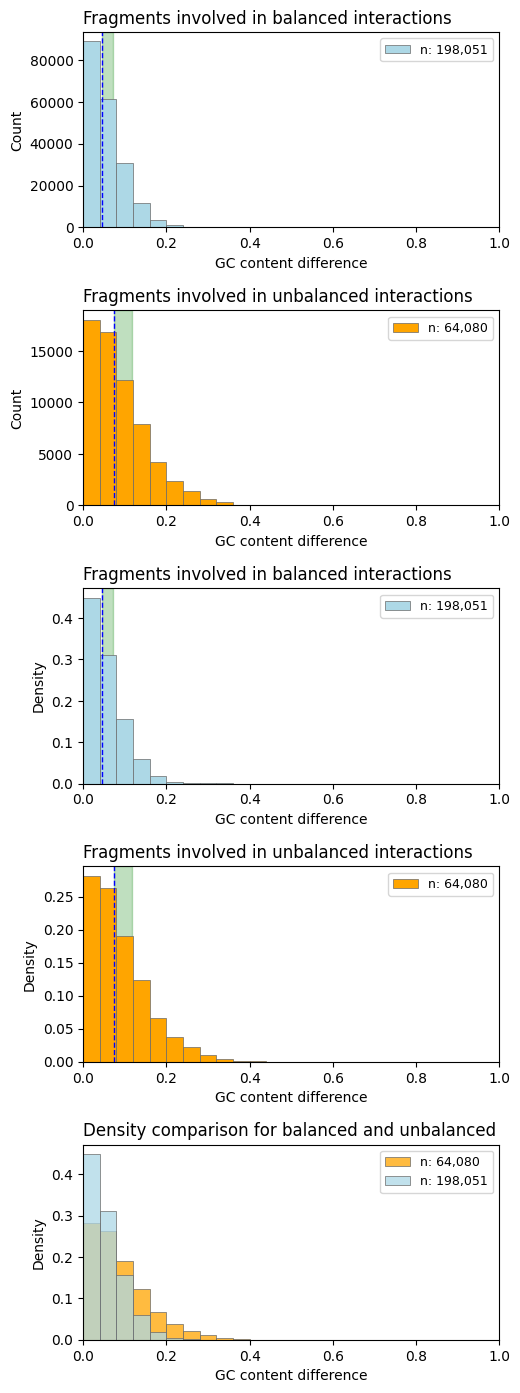

In [26]:
ub_frag_analysis.create_histplots(
    b_list = B_FRAG_ENDS_GC_53_DIFF_LIST,
    u_list = U_FRAG_ENDS_GC_53_DIFF_LIST,
    q_lim = 1.00,
    xlabel='GC content difference',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_diff_histograms.pdf')

## Repeat content analysis

For this analysis we combine the lists for the 5' and 3' ends:

In [27]:
B_FRAG_ENDS_REPEAT_LIST = B_FRAG_ENDS_REPEAT_5_LIST + B_FRAG_ENDS_REPEAT_3_LIST
U_FRAG_ENDS_REPEAT_LIST = U_FRAG_ENDS_REPEAT_5_LIST + U_FRAG_ENDS_REPEAT_3_LIST

### Report summary statistics and test

In [28]:
ub_frag_analysis.get_summary_report(b_list=B_FRAG_ENDS_REPEAT_LIST, u_list=U_FRAG_ENDS_REPEAT_LIST, test='MWU')

Fragments involved only in balanced interactions: 396,102
Fragments involved only in unbalanced interactions: 128,160
Median for fragments involved only in balanced interactions: 0.37
Median for fragments involved only in unbalanced interactions: 0.43
Test whether fragment lengths differ significantly: Balanced vs. unbalanced
	MannwhitneyuResult(statistic=23998332120.0, pvalue=6.076925965278397e-197)
	MannwhitneyuResult(statistic=26766100200.0, pvalue=6.076925965278397e-197)


### Create boxplots

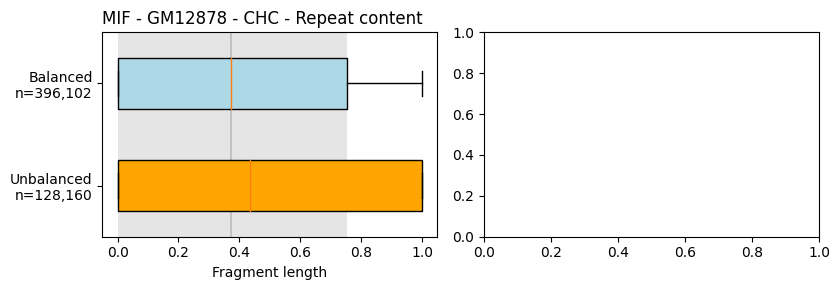

In [29]:
ub_frag_analysis.create_boxplots(
    u_list=U_FRAG_ENDS_REPEAT_LIST,
    b_list=B_FRAG_ENDS_REPEAT_LIST,
    showfliers=True,
    title= AUTHOR + ' - ' + CELL_TYPE_SHORT + ' - ' + PROTOCOL + ' - Repeat content',
    xlabel='Fragment length',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_boxplots.pdf')

### Create distribution histograms

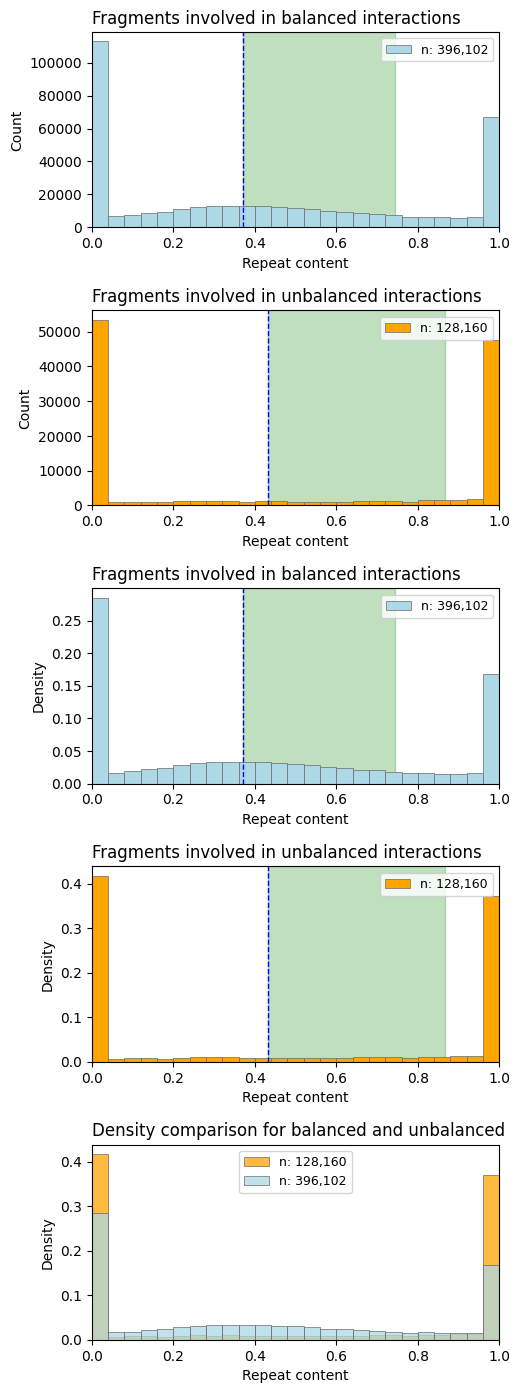

In [30]:
ub_frag_analysis.create_histplots(
    b_list = B_FRAG_ENDS_REPEAT_LIST,
    u_list = U_FRAG_ENDS_REPEAT_LIST,
    q_lim = 1.00,
    n_bins=30,
    xlabel='Repeat content',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_histograms.pdf')

## Absolute difference in repeat content of the two ends of given fragments

First, we calculate the absolute difference in the repeat content of the two ends for each fragment:

In [31]:
B_FRAG_ENDS_REPEAT_53_DIFF_LIST = [ abs(x[0]-x[1]) for x in zip(B_FRAG_ENDS_REPEAT_5_LIST, B_FRAG_ENDS_REPEAT_3_LIST)]
U_FRAG_ENDS_REPEAT_53_DIFF_LIST = [ abs(x[0]-x[1]) for x in zip(U_FRAG_ENDS_REPEAT_5_LIST, U_FRAG_ENDS_REPEAT_3_LIST)]

### Report summary statistics and test

In [32]:
ub_frag_analysis.get_summary_report(b_list=B_FRAG_ENDS_REPEAT_53_DIFF_LIST, u_list=U_FRAG_ENDS_REPEAT_53_DIFF_LIST, test='MWU')

Fragments involved only in balanced interactions: 198,051
Fragments involved only in unbalanced interactions: 64,080
Median for fragments involved only in balanced interactions: 0.27
Median for fragments involved only in unbalanced interactions: 0.29
Test whether fragment lengths differ significantly: Balanced vs. unbalanced
	MannwhitneyuResult(statistic=6008511634.0, pvalue=1.6450956512704002e-91)
	MannwhitneyuResult(statistic=6682596446.0, pvalue=1.6450956512704002e-91)


### Create boxplots

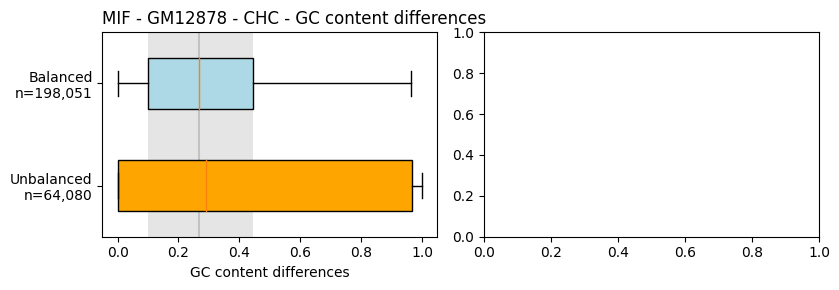

In [33]:
ub_frag_analysis.create_boxplots(
    u_list=U_FRAG_ENDS_REPEAT_53_DIFF_LIST,
    b_list=B_FRAG_ENDS_REPEAT_53_DIFF_LIST,
    showfliers=False,
    title= AUTHOR + ' - ' + CELL_TYPE_SHORT + ' - ' + PROTOCOL + ' - GC content differences',
    xlabel='GC content differences',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_difference.pdf')

### Create distribution histograms

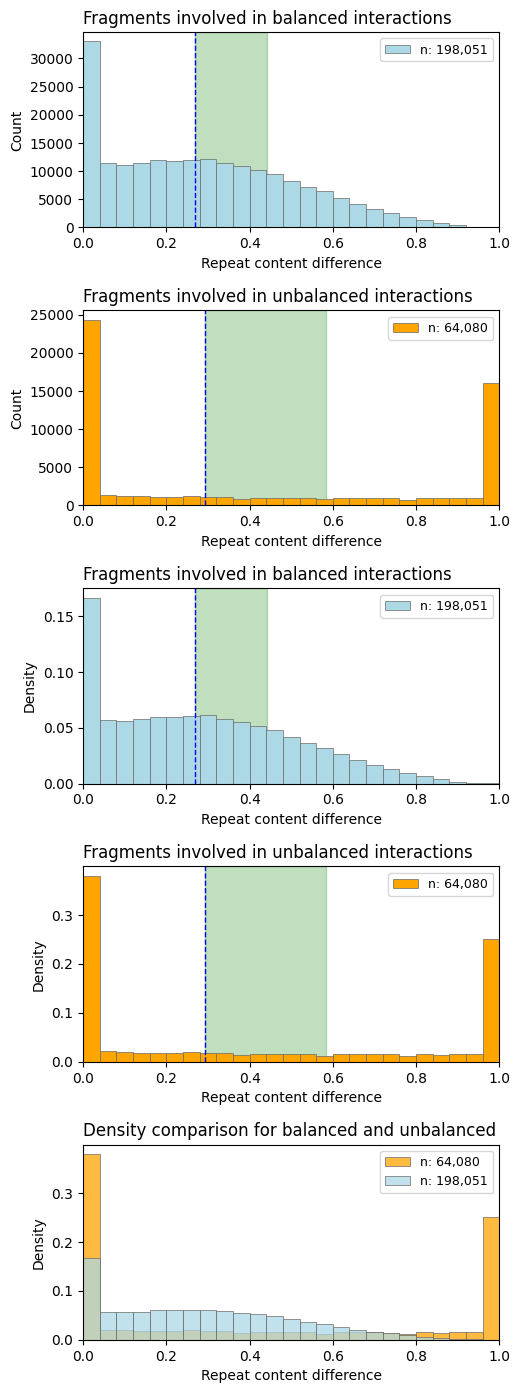

In [34]:
ub_frag_analysis.create_histplots(
    b_list = B_FRAG_ENDS_REPEAT_53_DIFF_LIST,
    u_list = U_FRAG_ENDS_REPEAT_53_DIFF_LIST,
    q_lim = 1.00,
    xlabel='Repeat content difference',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_diff_histograms.pdf')